### How much GPU memory does the GMM system takes, and how to reduce it...

In [1]:
import os,time
import numpy as np
import matplotlib.pyplot as plt

## use only one gpu
os.environ["CUDA_VISIBLE_DEVICES"]='0' 

## do not occupy entire memory so we can keep track
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #### reduce log output
import tensorflow as tf
floattype=np.float32

In [2]:
#### here we run in eager mode but the performance is the same for tf.function
## make sure tensorflow is working
a=tf.zeros(1)
## sleep a bit since nvidia-smi can have some delay
time.sleep(2)
os.system("nvidia-smi | grep eman");
## here 391mb is the base memory cost

|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python      391MiB |


In [3]:
## now check memory allocation
b=tf.zeros((512,32,64,64))
time.sleep(2)
os.system("nvidia-smi | grep eman");
## this should consume 256 mb of memory
## 647-391=256 

|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python      647MiB |


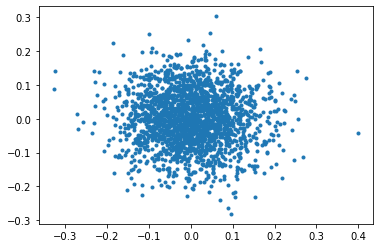

In [4]:
#### now start the real model
##   here npt is the number of Gaussian in the model
##   right now memory consumption scales linearly with npt

##   ideally we want the memory consumption to be independent from the number of Gaussian
##   only time consumption scales linearly

npt=2048
pts00=np.random.randn(npt,2)
pts00=pts00/(np.max(abs(pts00))*2.5)
plt.plot(pts00[:,0], pts00[:,1],'.')

(1, 2048, 2)
|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     1251MiB |


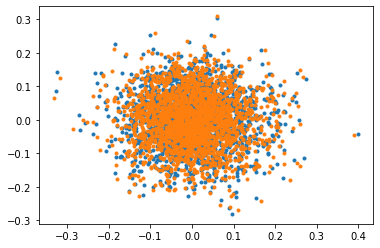

In [5]:
#### simple network to generate the Gaussian model
##   here we skip the projection step and operate only in 2d

layers=[
    tf.keras.layers.Dense(npt,input_shape=(2,)),
    tf.keras.layers.Dense(npt*2),
    tf.keras.layers.Reshape((npt,2)),
]
model=tf.keras.Sequential(layers)

##   add some noise so we have something to do in training
bs=pts00.flatten()+np.random.randn(npt*2)*.01
layers[-2].bias.assign(bs)

##   network output Gausian coordinates only
out=model(np.zeros((1,2), dtype=floattype))
print(out.shape)
plt.plot(pts00[:,0], pts00[:,1],'.')
plt.plot(out[0,:,0], out[0,:,1],'.')
time.sleep(2)
os.system("nvidia-smi | grep eman");

#### memory consumption of the network itself should scale with npt
#### this is small relative to the image formation steps later
##   here 604 mb of memory for the network

In [6]:
#### precompute some parameters for the calculations later
##   they are all in CPU memory so should not affect GPU memory usage

#### size of image. memory usage scales with N^2 of this.
boxsz=sz=64

#### precompute Fourier indices 
idx=np.indices((boxsz,boxsz))-boxsz//2
idx=np.fft.ifftshift(idx)
idx=idx[:,:,:boxsz//2+1]
idxft=(idx/sz).astype(floattype)[:, None, :,:]
rrft=np.sqrt(np.sum(idx**2, axis=0)).astype(floattype)## batch, npts, x-y
amp=tf.exp(-rrft*.1)

##  rings for FRC comparison later
rr=np.round(np.sqrt(np.sum(idx**2, axis=0))).astype(int)
rings=np.zeros((sz,sz//2+1,sz//2), dtype=floattype) #### Fourier rings
for i in range(sz//2):
    rings[:,:,i]=(rr==i)

time.sleep(2)
os.system("nvidia-smi | grep eman");

|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     1251MiB |


(1, 64, 33)
|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     1261MiB |


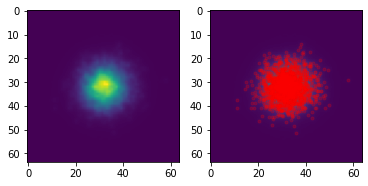

In [7]:
###################################################
#### Here comes the major issue of GPU memory usage...
##   to make 2d image out of Gaussian coordinates, we make 1 image per Gaussian, 
##   then sum them to form the final image
##   However tensorflow won't release memory for the intermediate images
##   since they will be used for gradient computing later, leading to high memory cost...
def pts2img(pts):

    bpos=pts*sz+sz/2
    bposft=bpos*np.pi*2
    bposft=bposft[:, :, :, None, None]
    
    ## this is the big 4d matrix for all Gaussian images
    ## (batchsz, # Gaussian, sz, sz//2+1)
    cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]

    ## here we keep amplitude constand for simplification
    ## amp should be (sz, sz//2+1)
    pgauss_real=tf.cos(cpxang)*amp
    pgauss_imag=-tf.sin(cpxang)*amp

    imgs_real=tf.reduce_sum(pgauss_real, axis=1)
    imgs_imag=tf.reduce_sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)

imgs_real, imgs_imag=pts2img(pts00[None,:,:].astype(floattype))
print(imgs_real.shape)
imgs_cpx=tf.complex(imgs_real, imgs_imag)
imgs_out=tf.signal.irfft2d(imgs_cpx)
img=imgs_out[0].numpy()
plt.subplot(1,2,1)
plt.imshow(img)
p=pts00*sz+sz//2
plt.subplot(1,2,2)
plt.imshow(img)
plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

time.sleep(2)
os.system("nvidia-smi | grep eman");

(16, 64, 33) (16, 64, 33)
|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     1261MiB |


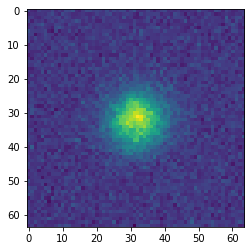

In [8]:
#### make some particle images for training later
##   they should stay in CPU as well
nptcl=16
ptcls=0.5*np.random.randn(nptcl, sz,sz)+img
plt.imshow(ptcls[0])
ptcls_cpx=np.fft.rfft2(ptcls)
ptcls_real=np.real(ptcls_cpx).astype(floattype)
ptcls_imag=np.imag(ptcls_cpx).astype(floattype)
print(ptcls_real.shape, ptcls_imag.shape)

time.sleep(2)
os.system("nvidia-smi | grep eman");

In [9]:
#### now make corresponding images from the model
##   note here the memory consumption already increase linear to Gaussian number
##   since tensorflow does not release memory for the 4d matrix
pp=model(np.zeros((nptcl,2), dtype=floattype))
print(pp.shape)
imgs_cpx=pts2img(pp)
print(imgs_cpx[0].shape)

time.sleep(2)
os.system("nvidia-smi | grep eman");

(16, 2048, 2)
(16, 64, 33)
|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     2797MiB |


|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     2797MiB |


0

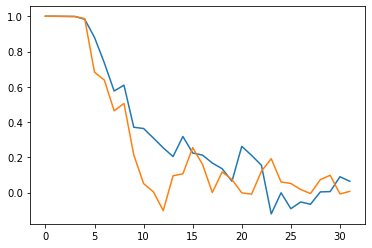

In [10]:
#### calculate FRC. 
##   the memory consumption here seeme reasonable. 
def calc_frc(data_cpx, imgs_cpx, rings, return_curve=False, minpx=2):
    mreal, mimag=imgs_cpx
    dreal, dimag=data_cpx
    #### normalization per ring
    nrm_img=mreal**2+mimag**2
    nrm_data=dreal**2+dimag**2

    nrm0=tf.tensordot(nrm_img, rings, [[1,2],[0,1]])
    nrm1=tf.tensordot(nrm_data, rings, [[1,2],[0,1]])

    nrm=tf.sqrt(nrm0)*tf.sqrt(nrm1)
    nrm=tf.maximum(nrm, 1e-4) #### so we do not divide by 0

    #### average FRC per batch
    ccc=mreal*dreal+mimag*dimag
    frc=tf.tensordot(ccc, rings, [[1,2],[0,1]])/nrm

    if return_curve:
        return frc
    else:
        frcval=tf.reduce_mean(frc[:, minpx:], axis=1)
        return frcval

data_cpx=(ptcls_real, ptcls_imag)
frc=calc_frc(data_cpx, imgs_cpx, rings, True)
plt.plot(frc[0])
plt.plot(frc[1])
calc_frc(data_cpx, imgs_cpx, rings)

time.sleep(2)
os.system("nvidia-smi | grep eman");

In [11]:
#### now do training for the network 
##   more memory usage since we are tracking gradient
##   also note that if we comment out the image generation two cells ago, 
##   the total memory consumption here would be unchanged.

wts=model.trainable_variables
opt=tf.keras.optimizers.Adam(learning_rate=1e-4) 

for it in range(10):
    with tf.GradientTape() as gt:
        pp=model(np.zeros((nptcl,2), dtype=floattype))
        imgs_cpx=pts2img(pp)

        fval=calc_frc(data_cpx, imgs_cpx, rings)
        loss=-tf.reduce_mean(fval)

    grad=gt.gradient(loss, wts)
    opt.apply_gradients(zip(grad, wts))
    df=pp[0]-pts00
    df=np.mean(np.linalg.norm(df, axis=1))
    print(it, loss.numpy(), df)
    
time.sleep(2)
os.system("nvidia-smi | grep eman");

0 -0.277704 0.012250682
1 -0.2864101 0.0122275
2 -0.2951001 0.012206221
3 -0.30397254 0.012186493
4 -0.3127905 0.01216859
5 -0.321107 0.012153683
6 -0.3284611 0.012143696
7 -0.33455455 0.012140287
8 -0.339328 0.0121440645
9 -0.3429392 0.012154682
|    0   N/A  N/A   2700724      C   ...da3/envs/eman2/bin/python     4845MiB |


0